# Circulation Analysis

This notebook investigates the zonal average overturning circulation in the meridional/pressure plane. The idea is to see if it has the Hadley and Ferrel cell structure that the Earth does.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, lapse_moist
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, frierson_sw_optical_depth, frierson_atmospheric_heating
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v, radius_earth
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_mean, annual_time_slice
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
from scipy.interpolate import UnivariateSpline

2023-04-18 12:26:27,509 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


## Aquaplanet

In [2]:
exp_dir = 'tau_sweep/aquaplanet/'
var_keep = ['ucomp', 'vcomp', 'omega']      # only keep winds
tau_lw = 1
tau_lw_warm = 1.5
exp_names = [f"k={str(tau_lw).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
evap_param = []

# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2

for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    # Take zonal and time mean
    ds += [ds_use.sel(time=slice(use_time_start, np.inf)).mean(dim=['time', 'lon']).load()]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    try:
        evap_param += [namelist['surface_flux_nml']['land_evap_prefactor']]
    except KeyError:
        print(f'Experiment {i}: Evap param not specified so set to default value of 1')
        evap_param += [1]


Experiment 0: Evap param not specified so set to default value of 1
Experiment 1: Evap param not specified so set to default value of 1


### Time and zonal mean circulation
Below we clearly see that we have a double ITCZ - an ITCZ in each hemisphere at pressures above $600hPa$ with descent at the equator.

In [3]:
n_p = ds[0].pfull.size
n_lat = ds[0].lat.size
stream = [np.zeros((n_p, n_lat)), np.zeros((n_p, n_lat))]
cos_lat = np.asarray(np.cos(np.deg2rad(ds[0].lat)))
for k in range(n_exp):
    for i in range(n_p):
        stream[k][i] = integrate.simpson(ds[k].vcomp[:i+1], ds[k].pfull[:i+1] * 100, axis=0)
        stream[k][i] = 2 * np.pi * radius_earth * cos_lat[np.newaxis] / g * stream[k][i]  # get into correct units of kg/s

In [4]:
def plot_circulation(ds_list, stream_list, stream_max=None):
    # Plots the 3 velocities: u, v and omega in the zonal/time mean as function of pressure and latitude.
    # Also plots the meridional-vertical streamfunction in the zonal/time mean.
    u_max = np.asarray([np.abs(ds_list[i].ucomp).max() for i in range(n_exp)]).max()
    v_max = np.asarray([np.abs(ds_list[i].vcomp).max() for i in range(n_exp)]).max()
    omega_max = np.asarray([np.abs(ds_list[i].omega).max() for i in range(n_exp)]).max()
    if stream_max is None:
        stream_max = np.asarray([np.abs(stream_list[i]).max() for i in range(n_exp)]).max() /10**10
    labels = ['$[u]$ / $ms^{-1}$', '$[v]$ / $ms^{-1}$', '$[\omega]$ / $Pas^{-1}$', '$[\psi]$ / $10^{10} kgs^{-1}$']
    var_max = [u_max, v_max, omega_max, stream_max]
    var_diff = [ds_list[1].get(var)-ds_list[0].get(var) for var in ['ucomp', 'vcomp', 'omega']]
    var_diff += [(stream_list[1] - stream_list[0])/10**10]

    fig, ax = plt.subplots(4,3, figsize=(14, 10), sharex=True, sharey=True)
    for i in range(n_exp):
        for k, var  in enumerate([ds_list[i].ucomp, ds_list[i].vcomp, ds_list[i].omega, stream_list[i]/10**10]):
            if 'omega' in labels[k]:
                cmap = 'bwr_r'      # reverse cmap for pressure velocity
            else:
                cmap = 'bwr'
            im = ax[k, i].pcolormesh(ds_list[0].lat, ds_list[0].pfull, var, cmap=cmap, shading='gouraud',
                                     vmin=-var_max[k], vmax=var_max[k])
            if i == 0:
                im = ax[k, -1].pcolormesh(ds_list[0].lat, ds_list[0].pfull, var_diff[k], cmap=cmap, shading='gouraud',
                                          vmin=-var_max[k], vmax=var_max[k])
                plt.colorbar(im, ax=ax[k, -1], label=labels[k])
    ax[0, 0].invert_yaxis()
    ax[0,0].set_title(f'$\kappa = {tau_lw[0]}$')
    ax[0,1].set_title(f'$\kappa = {tau_lw[1]}$')
    ax[0,2].set_title(f'$(\kappa = {tau_lw[1]}) - (\kappa = {tau_lw[0]})$')
    fig.supxlabel('Latitude')
    fig.supylabel('Pressure / $hPa$')
    plt.tight_layout()
    return fig, ax

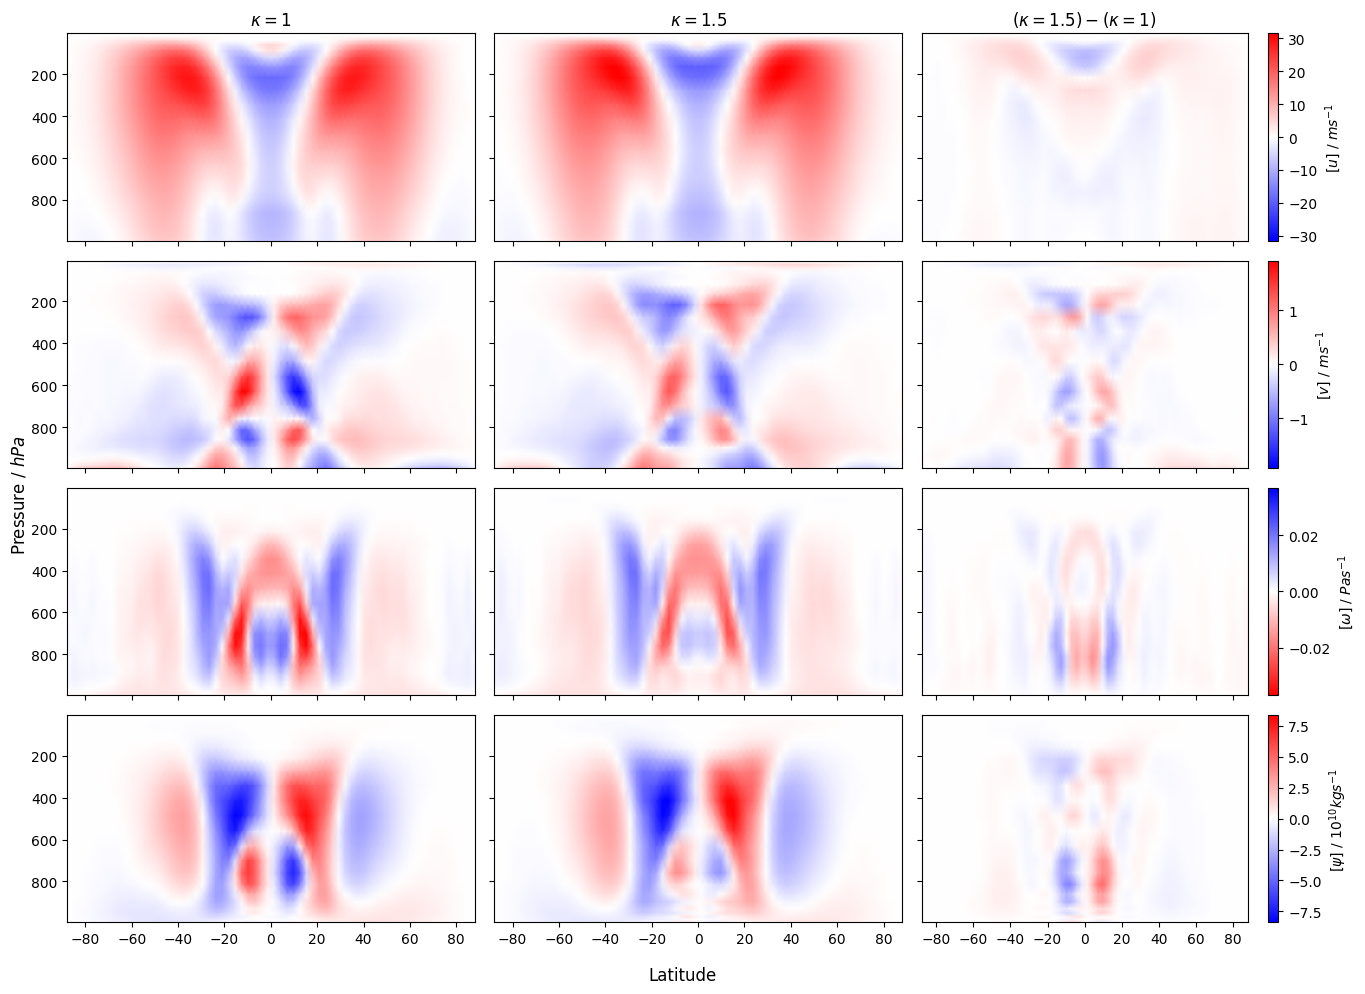

In [5]:
plot_circulation(ds, stream);

### Seasonal variation of zonal mean circulation
From the first plot below, we see that in the above plots, we are averaging all the seasons together which obscures the actual overturning circulation.

We see we get ascent in summer hemisphere summer between December to April, from around -20 to the equator. We get the same in northern hemisphere summer from June to October, from the equator to around 20 degrees.


In [43]:
pressure_ft = 500
omega_ft = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds_use = ds_use.sel(pfull=pressure_ft, method='nearest')       # just keep free troposphere pressure
    # Take zonal and time mean
    ds_use = ds_use.sel(time=slice(use_time_start, np.inf)).mean(dim='lon')
    omega_ft += [annual_mean(ds_use.omega).load()]

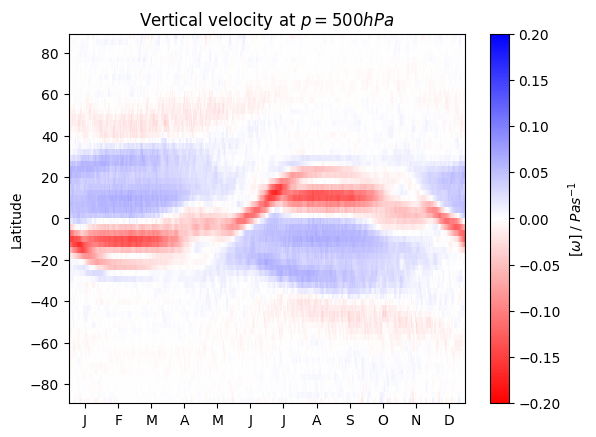

In [54]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

fig, ax = plt.subplots(1,1)
im = ax.pcolormesh(omega_ft[0].time, omega_ft[0].lat, omega_ft[0].transpose(), cmap='bwr_r', vmin=-0.2, vmax=0.2)
plt.colorbar(im, ax=ax, label='$[\omega]$ / $Pas^{-1}$')
ax.set_xticks(*month_ticks)
ax.set_ylabel('Latitude')
ax.set_title(f'Vertical velocity at $p={pressure_ft}hPa$');

In the next plot, we show the circulation averaged over all northern hemisphere summer (JAS) days. The streamfunction plot shows that we have an extremely large cross equatorial Hadley cell in the winter hemisphere from about -20 to 20. The summer hemisphere Hadley cell is tiny, from about 20 to 30 degrees. We also see Farrel cells adjacent to the Hadley cells, from around 30 to 60 degrees in each hemisphere.

In [45]:
ds_nhs = []       # July, August, September from the above plot
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep + ['height']]
    # Take zonal and time mean
    ds_use = ds_use.sel(time=slice(use_time_start, np.inf))
    ds_nhs += [annual_time_slice(ds_use, include_months=[7, 8, 9]).mean(dim=['lon', 'time']).load()]

In [46]:
stream_nhs = [np.zeros((n_p, n_lat)), np.zeros((n_p, n_lat))]
for k in range(n_exp):
    for i in range(n_p):
        stream_nhs[k][i] = integrate.simpson(ds_nhs[k].vcomp[:i+1], ds_nhs[k].pfull[:i+1] * 100, axis=0)
        # get into correct units of kg/s
        stream_nhs[k][i] = 2 * np.pi * radius_earth * cos_lat[np.newaxis] / g * stream_nhs[k][i]

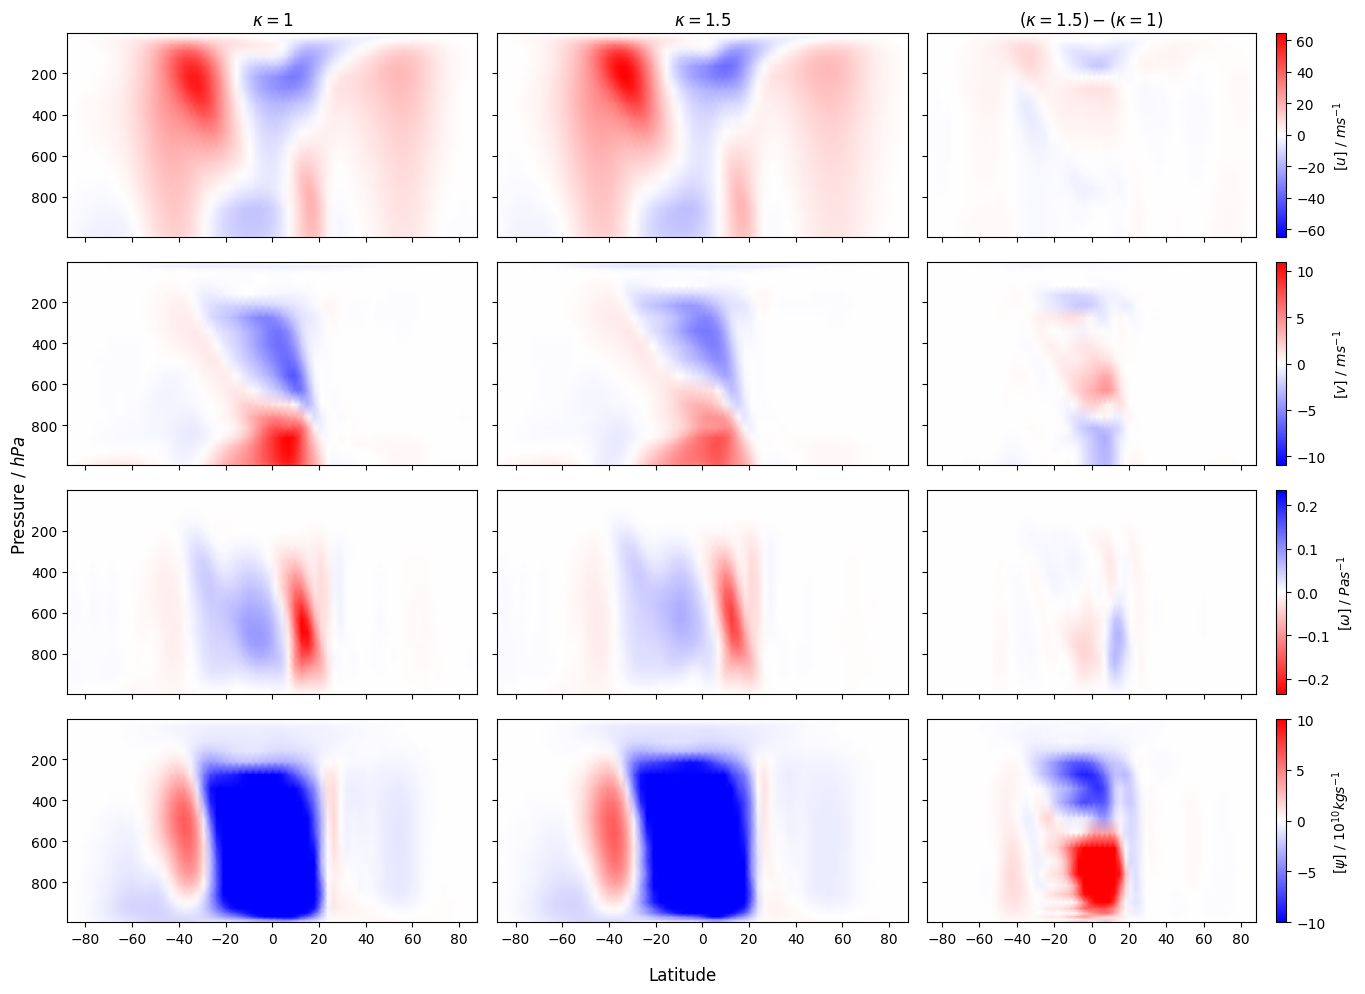

In [47]:
plot_circulation(ds_nhs, stream_nhs, 10);

## Circulation on High Quantile Days

Below compares the circulation on the average northern hemisphere summer day to that on days/longitudes which have surface temperature exceeding a given high quantile in a given latitude region. The most obvious differences are shown in the streamfunction (bottom plot).

#### Tropics
In the Tropics, there is a slightly wider and stronger summer hemisphere Hadley cell and a much stronger summer hemisphere Ferrel cell.

#### Extra-tropics
In the Extra-tropics, the summer hemisphere Hadley cell is significantly stronger and wider. This leads to more ascent (negative $\omega$) and poleward flow (positive $v$) in the extra-tropics.

#### High-latitudes
In the high-latitudes, the summer hemisphere Hadley and Polar cells are much stronger than for the mean summer day. There is correspondingly more poleward flow at high latitudes i.e. more sub-polar air is entering the polar region when it is hottest.

In [348]:
# Get dataset averaged over all days and longitudes with a maximum surface temperature in the latitude region specified above
# the quant_use percentile in that latitude region.
quant_use = 99
region = 'Tropics'
lat_min = 0
lat_max = 20
# region = 'Extra-tropics'
# lat_min = 30
# lat_max = 60
# region = 'High Latitudes'
# lat_min = 80
# lat_max = 90

ds_quant = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep + ['temp', 'height']]
    # Take zonal and time mean
    ds_use = ds_use.sel(time=slice(use_time_start, np.inf))
    # Compute threshold temperature as quant_use percentile surface temperature across all time, lon, lat in given latitude range
    temp_use = ds_use.temp.sel(pfull=np.inf, method='nearest', drop=True).where(np.logical_and(ds_use.lat<=lat_max, ds_use.lat>lat_min),
                                                                                drop=True).chunk(dict(time=-1))
    quant_thresh = float(temp_use.quantile(quant_use/100, dim=['lon', 'lat', 'time']))
    # Only keep times and longitudes where max temperature in given latitude range is above threshold temperature
    keep_time_lon = ds_use.where(np.logical_and(ds_use.lat<lat_max, ds_use.lat>lat_min),
                                 drop=True).temp.sel(pfull=np.inf, method='nearest',
                                                     drop=True).max(dim=['lat']).chunk(dict(time=-1)) >= quant_thresh
    keep_time_lon = keep_time_lon.to_numpy()

    # Keep data only corresponding to the time, longitude pairs
    keep_times = xr.DataArray(ds_use.time[np.where(keep_time_lon)[0]].to_numpy(), dims=['time_lon'])
    keep_lon = xr.DataArray(ds_use.lon[np.where(keep_time_lon)[1]].to_numpy(), dims=['time_lon'])

    # Take average over this time-longitude dimension
    ds_use = ds_use.sel(time=keep_times, lon=keep_lon, method="nearest").mean(dim='time_lon')
    ds_quant += [ds_use.load()]

In [349]:
stream_quant = [np.zeros((n_p, n_lat)), np.zeros((n_p, n_lat))]
for k in range(n_exp):
    for i in range(n_p):
        stream_quant[k][i] = integrate.simpson(ds_quant[k].vcomp[:i+1], ds_quant[k].pfull[:i+1] * 100, axis=0)
        # get into correct units of kg/s
        stream_quant[k][i] = 2 * np.pi * radius_earth * cos_lat[np.newaxis] / g * stream_quant[k][i]

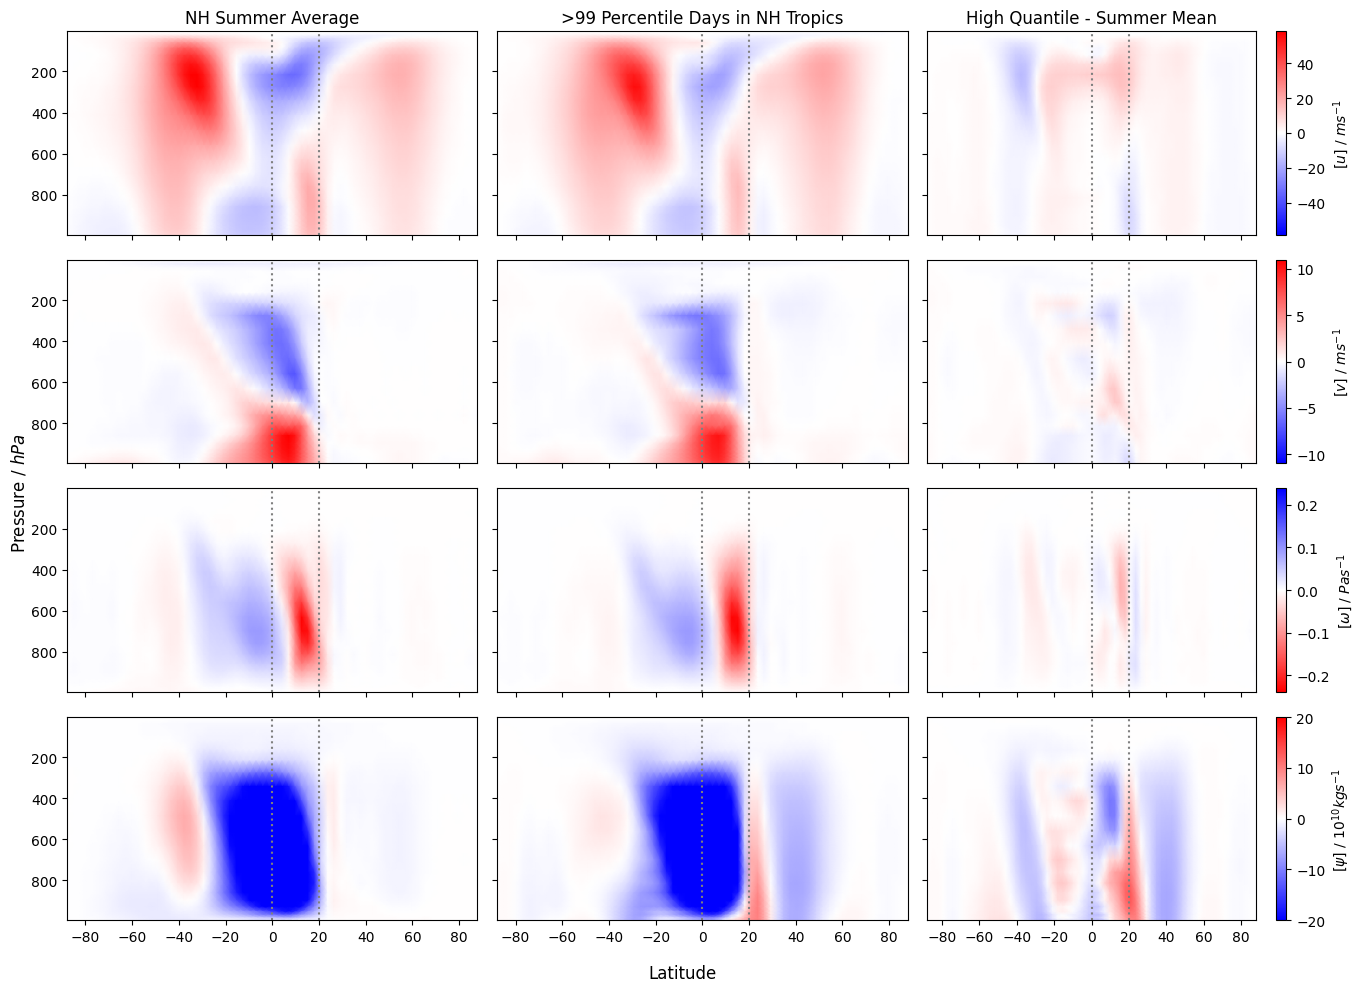

In [350]:
# Compare circulation on high quantile temperature day to that on average summer day
fig, ax = plot_circulation([ds_nhs[0], ds_quant[0]], [stream_nhs[0], stream_quant[0]], 20)
ax[0,0].set_title('NH Summer Average')
ax[0,1].set_title(f'>{quant_use} Percentile Days in NH {region}')
ax[0,2].set_title('High Quantile - Summer Mean')
for ax_use in ax.flatten():
    # Highlight the latitude region, over which we got high percentile
    ax_use.vlines(lat_min, ds_nhs[0].pfull[-1], ds_nhs[0].pfull[0], color='grey', linestyles=':')
    ax_use.vlines(lat_max, ds_nhs[0].pfull[-1], ds_nhs[0].pfull[0], color='grey', linestyles=':')

### Geopotential Height
The plots below show the difference between the geopotential height on very hot days compared to the northern hemisphere average. Again, we see clear differences between the hot tropics days compared to the hot extra-tropics and polar days.

#### Tropics
For the hottest tropics days, we see a reduced $z$ and thus reduced pressure at latitude > 20 degrees. This coincides with the stronger Ferrel cell that we see in this hemisphere. We also see increased pressure at latitude < -40 degrees. This coincides with the weaker Ferrel cell in this hemisphere.

#### Extratropics
For the hottest extratropics days, we see greater pressure at latitude > 20 degrees. This coincides with the stronger Hadley cell that we see in this hemisphere. We also see reduced pressure at latitude < -40 degrees. This coincides with the stronger Ferrel cell that we see in this hemisphere.

#### High-latitude
The high-latitude plots look very similar to that of the extratropics, except there is a slightly greater increase in pressure at the northern hemisphere pole on the hottest days. This coincides with the stronger Polar cell that we see in this hemisphere.

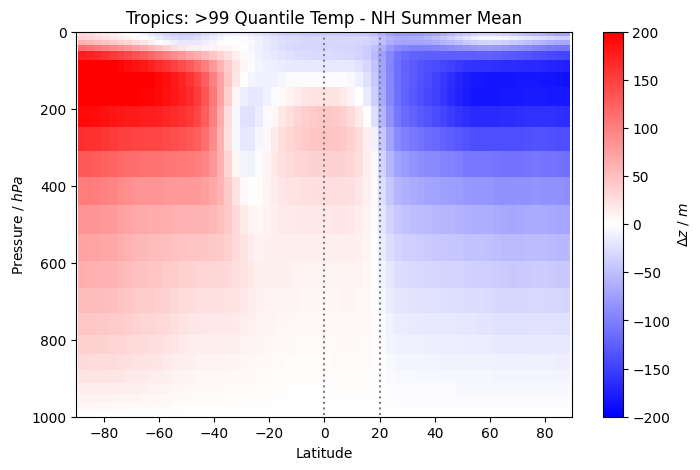

In [351]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
im = ax.pcolormesh(ds_quant[0].lat, ds_quant[0].pfull, ds_quant[0].height - ds_nhs[0].height, vmax=200, vmin=-200, cmap='bwr')
plt.colorbar(im, ax=ax, label=f'$\Delta z$ / $m$')
ax.vlines(lat_min, ds_nhs[0].pfull[-1], ds_nhs[0].pfull[0], color='grey', linestyles=':')
ax.vlines(lat_max, ds_nhs[0].pfull[-1], ds_nhs[0].pfull[0], color='grey', linestyles=':')
ax.set_xlabel('Latitude')
ax.set_ylabel('Pressure / $hPa$')
ax.set_title(f'{region}: >{quant_use} Quantile Temp - NH Summer Mean')
ax.invert_yaxis()
ax.set_xlim(-90,90);

In [368]:
ds_use = isca_tools.load_dataset(exp_dir + exp_names[0])[var_keep + ['temp', 'height', 'vor', 'ucomp', 'vcomp', 'ps']]
ds_use = ds_use.sel(time=slice(use_time_start, np.inf))

temp_use = ds_use.temp.sel(pfull=np.inf, method='nearest', drop=True).where(np.logical_and(ds_use.lat<=lat_max, ds_use.lat>lat_min),
                                                                            drop=True).chunk(dict(time=-1))
max_ind = temp_use.argmax(dim=['time', 'lon', 'lat'])
max_ind = {key: int(max_ind[key]) for key in max_ind}
max_coords = {key: float(temp_use._getitem_coord(key)[max_ind[key]]) for key in max_ind}

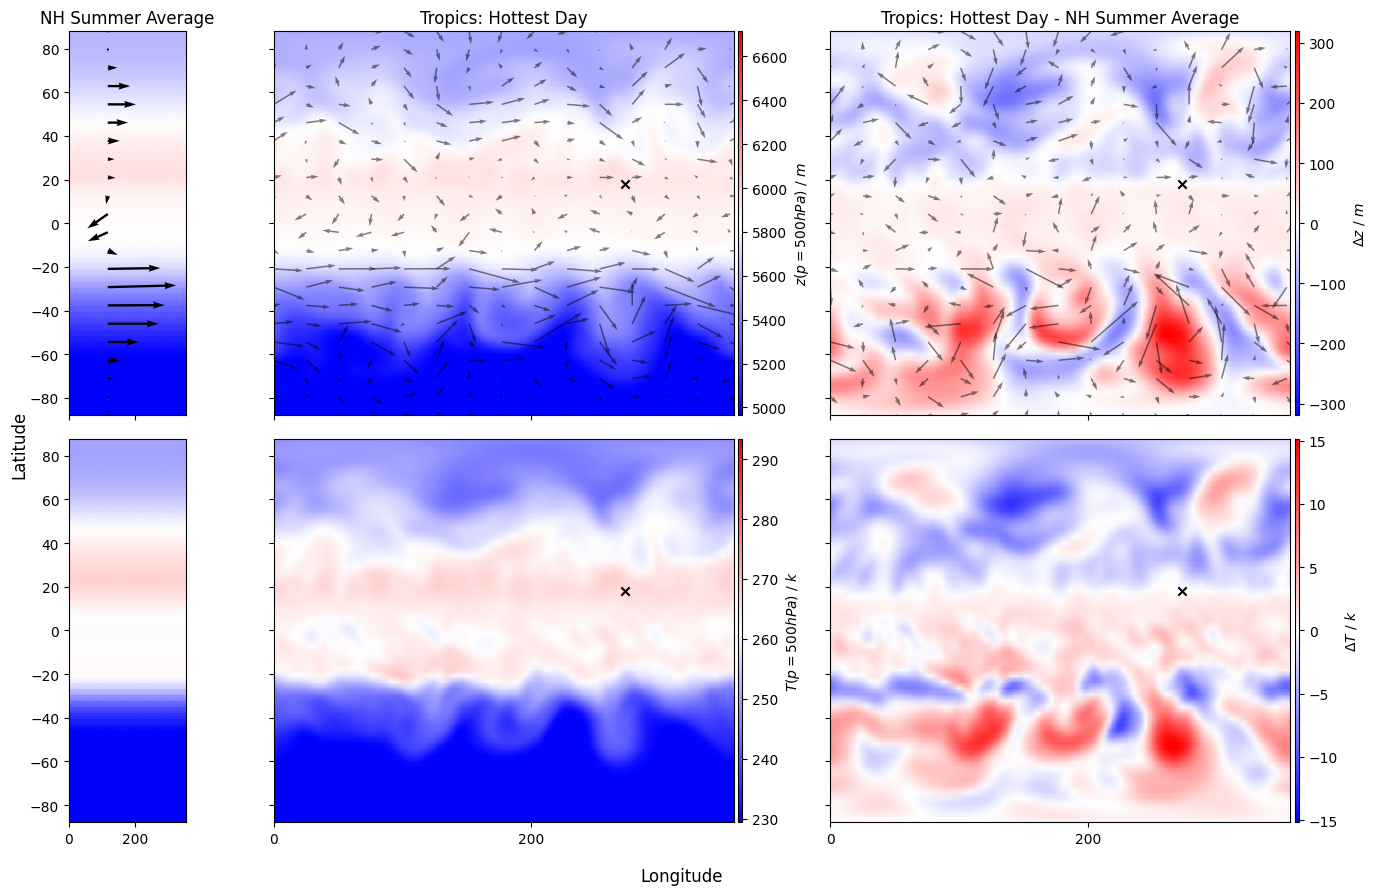

In [449]:
# Plot free troposphere geopotential height and temperature
nh_mean = annual_time_slice(ds_use.where(ds_use.lat>=-np.inf, drop=True),
                            include_months=[7, 8, 9]).sel(pfull=[pressure_ft, np.inf],
                                                          method='nearest').mean(dim=['time'])[
    ['ps', 'height', 'temp', 'vor', 'ucomp', 'vcomp']]

# take mean across longitude for each latitude as they are equivalent on aquaplanet, then reshape to keep longitude coordinate
# treat surface pressure separately as has only 1 pressure value
nh_mean = nh_mean.mean(dim='lon')
nh_mean_ps = nh_mean.ps
nh_mean_ps = nh_mean_ps.expand_dims(dim={"lon": ds_use.lon.size}, axis=1)
nh_mean_ps['lon'] = ds_use.lon
nh_mean = nh_mean.drop_vars('ps')
nh_mean = nh_mean.expand_dims(dim={"lon": ds_use.lon.size}, axis=2)
nh_mean['lon'] = ds_use.lon

ds_max = ds_use.where(ds_use.lat>=-np.inf, drop=True).sel(pfull=[pressure_ft, np.inf], time=max_coords['time'], method='nearest')
var_symbol = ['z', 'T']
fig, ax = plt.subplots(2,3, figsize=(14, 9), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 4, 4]})
for i, var in enumerate(['height', 'temp']):
    cmap_centre = float(nh_mean.get(var)[0].quantile(0.7))
    cmap_range = float(np.abs((nh_mean.get(var)[0]-cmap_centre)).max()) * 0.8
    im = ax[i, 0].pcolormesh(ds_max.lon, ds_max.lat, nh_mean.get(var)[0],
                             cmap='bwr', vmin=cmap_centre-cmap_range, vmax=cmap_centre+cmap_range, shading='gouraud')

    im = ax[i, 1].pcolormesh(ds_max.lon, ds_max.lat, ds_max.get(var)[0], cmap='bwr',
                       vmin=cmap_centre-cmap_range, vmax=cmap_centre+cmap_range, shading='gouraud')
    plt.colorbar(im, ax=ax[i, 1], label=f'${var_symbol[i]} (p={pressure_ft}hPa)$ / ${ds_max.get(var).units[-1]}$',
                 aspect=100, pad=0.01, fraction=0.01)
    ax[i, 1].scatter(max_coords['lon'], max_coords['lat'], marker='x', color='k')

    cmap_range = float((ds_max.get(var)[0]-nh_mean.get(var)[0]).max())
    im = ax[i, 2].pcolormesh(ds_max.lon, ds_max.lat, ds_max.get(var)[0]-nh_mean.get(var)[0], cmap='bwr',
                       vmin=-cmap_range, vmax=cmap_range, shading='gouraud')
    plt.colorbar(im, ax=ax[i, 2], label=f'$\Delta {var_symbol[i]}$ / ${ds_max.get(var).units[-1]}$',
                 aspect=100, pad=0.01, fraction=0.01)
    ax[i, 2].scatter(max_coords['lon'], max_coords['lat'], marker='x', color='k')
ax[0, 0].set_title('NH Summer Average')
ax[0, 1].set_title(f'{region}: Hottest Day')
ax[0, 2].set_title(f'{region}: Hottest Day - NH Summer Average')
fig.supylabel('Latitude')
fig.supxlabel('Longitude')
# Plot average winds
lon_mid_ind = int(ds_use.lon.size/3)  # for average summer plot, only plot one arrow for each latitude as all the same
pu, pv = nh_mean.ucomp[0][::3,lon_mid_ind:lon_mid_ind+1], nh_mean.vcomp[0][::3,lon_mid_ind:lon_mid_ind+1]
ax[0, 0].quiver(pu.lon, pu.lat, pu, pv, width=0.02, scale=50)
# Plot  wind on hottest day
pu, pv = (ds_max.ucomp[0])[::3,::9], (ds_max.vcomp[0])[::3,::9]
ax[0, 1].quiver(pu.lon, pu.lat, pu, pv, alpha=0.5)
# Plot deviation from average wind on hottest day
pu, pv = (ds_max.ucomp[0]-nh_mean.ucomp[0])[::3,::9], (ds_max.vcomp[0]-nh_mean.vcomp[0])[::3,::9]
ax[0, 2].quiver(pu.lon, pu.lat, pu, pv, alpha=0.5)
plt.tight_layout();

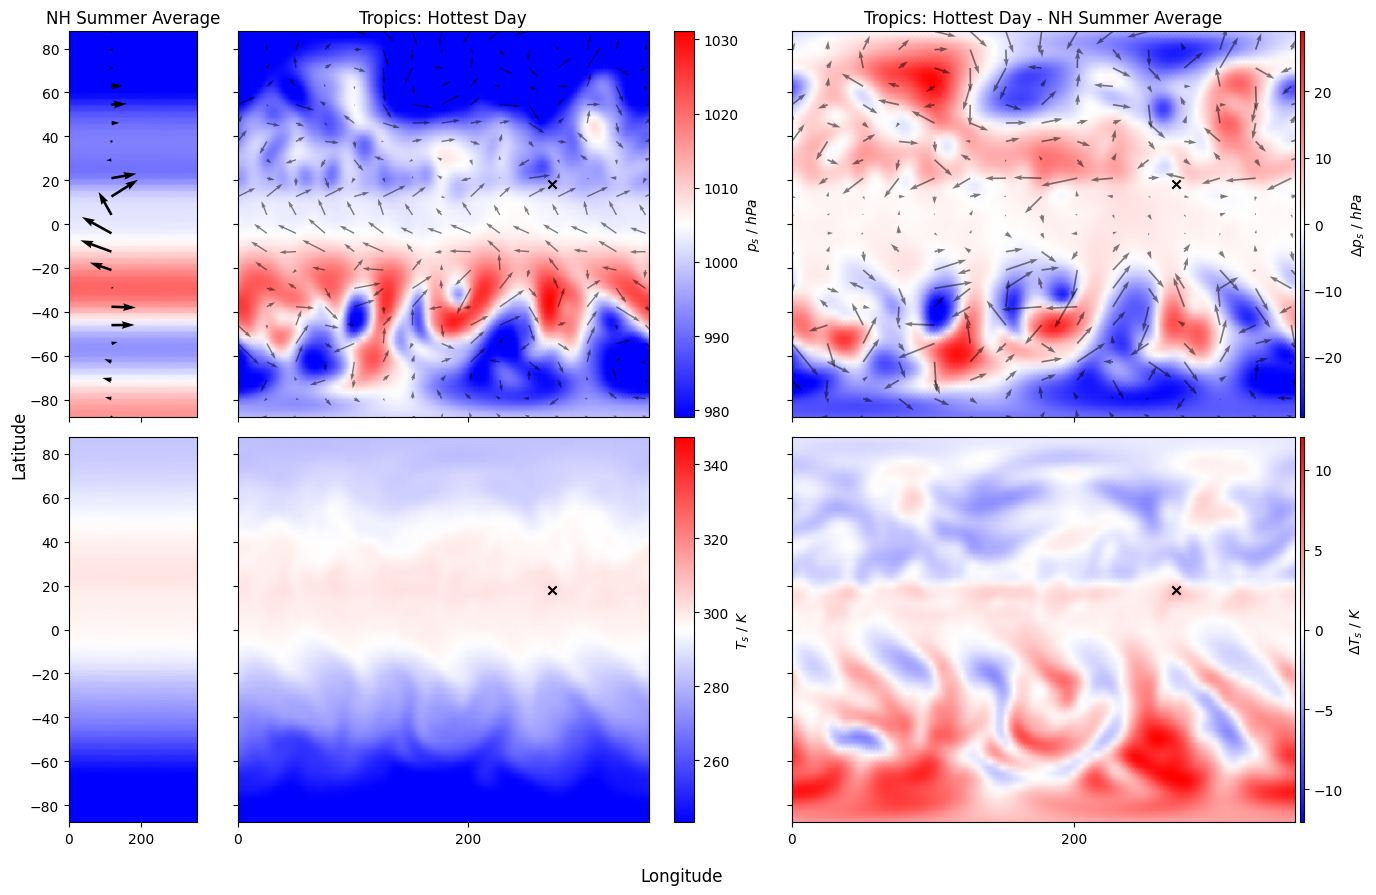

In [450]:
# Plot surface pressure and temperature
fig, ax = plt.subplots(2,3, figsize=(14, 9), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 4, 4]})
for i in range(2):
    if i == 0:
        label = '$p_s$ / $hPa$'
        var_max = ds_max.ps/100
        var = nh_mean_ps/100
    else:
        label = '$T_s$ / $K$'
        var_max = ds_max.temp[1]
        var = nh_mean.temp[1]
    cmap_centre = float(var.quantile(0.7))
    cmap_range = float(np.abs((var-cmap_centre)).max()) * 0.8
    im = ax[i, 0].pcolormesh(ds_max.lon, ds_max.lat, var, cmap='bwr',
                          vmin=cmap_centre-cmap_range, vmax=cmap_centre+cmap_range, shading='gouraud')

    im = ax[i, 1].pcolormesh(ds_max.lon, ds_max.lat, var_max, cmap='bwr',
                       vmin=cmap_centre-cmap_range, vmax=cmap_centre+cmap_range, shading='gouraud')
    plt.colorbar(im, ax=ax[i, 1], label=label)
    ax[i, 1].scatter(max_coords['lon'], max_coords['lat'], marker='x', color='k')

    cmap_range = float((var_max-var).max())
    im = ax[i, 2].pcolormesh(ds_max.lon, ds_max.lat, var_max-var, cmap='bwr',
                             vmin=-cmap_range, vmax=cmap_range, shading='gouraud')
    plt.colorbar(im, ax=ax[i, 2], label=f'$\Delta${label}',
                 aspect=100, pad=0.01, fraction=0.01)
    ax[i, 2].scatter(max_coords['lon'], max_coords['lat'], marker='x', color='k')

ax[0, 0].set_title('NH Summer Average')
ax[0, 1].set_title(f'{region}: Hottest Day')
ax[0, 2].set_title(f'{region}: Hottest Day - NH Summer Average')
fig.supylabel('Latitude')
fig.supxlabel('Longitude')
# Plot average winds
pu, pv = nh_mean.ucomp[1][::3,lon_mid_ind:lon_mid_ind+1], nh_mean.vcomp[1][::3,lon_mid_ind:lon_mid_ind+1]
ax[0, 0].quiver(pu.lon, pu.lat, pu, pv, width=0.02, scale=50)
# Plot wind on hottest day
pu, pv = (ds_max.ucomp[1])[::3,::9], (ds_max.vcomp[1])[::3,::9]
ax[0, 1].quiver(pu.lon, pu.lat, pu, pv, alpha=0.5)
# Plot deviation from average wind on hottest day
pu, pv = (ds_max.ucomp[1]-nh_mean.ucomp[1])[::3,::9], (ds_max.vcomp[1]-nh_mean.vcomp[1])[::3,::9]
ax[0, 2].quiver(pu.lon, pu.lat, pu, pv, alpha=0.5)
plt.tight_layout();

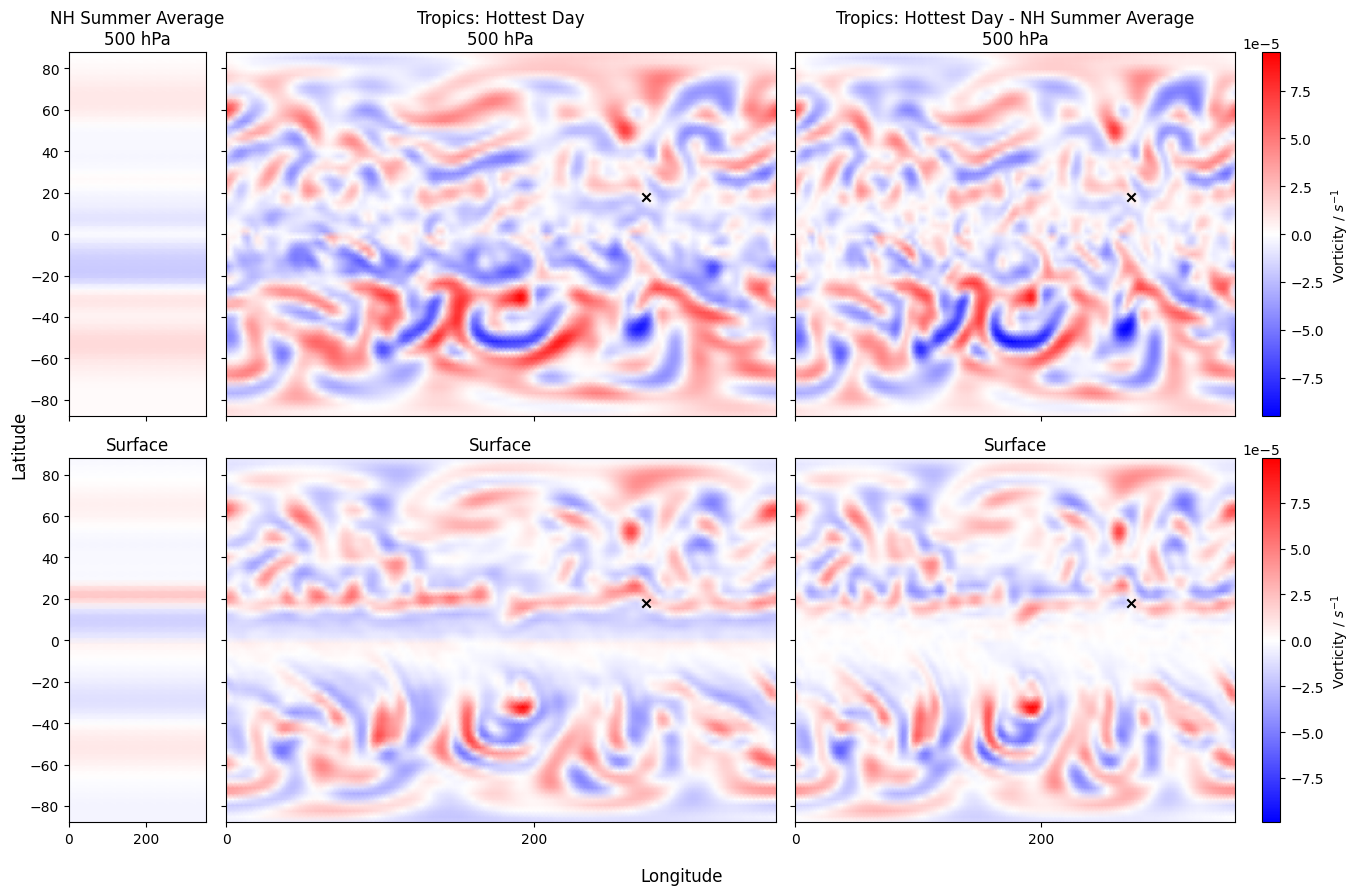

In [452]:
# Plot vorticity
# I multiply vorticity by the sign of the latitude so negative always means anticyclonic and positive means cyclonic
fig, ax = plt.subplots(2,3, figsize=(14, 9), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 4, 4]})
for i in range(2):
    cmap_range = np.max([float((np.abs(nh_mean.vor[i])).max()), float((np.abs(ds_max.vor[i])).max())])
    im = ax[i, 0].pcolormesh(ds_max.lon, ds_max.lat, nh_mean.vor[i] * np.sign(nh_mean.vor[i].lat), cmap='bwr',
                          vmin=-cmap_range, vmax=cmap_range, shading='gouraud')
    im = ax[i, 1].pcolormesh(ds_max.lon, ds_max.lat, ds_max.vor[i] * np.sign(ds_max.vor[i].lat), cmap='bwr',
                       vmin=-cmap_range, vmax=cmap_range, shading='gouraud')
    # plt.colorbar(im, ax=ax[i, 1], label='Vorticity / $s^{-1}$')
    ax[i, 1].scatter(max_coords['lon'], max_coords['lat'], marker='x', color='k')

    im = ax[i, 2].pcolormesh(ds_max.lon, ds_max.lat, ds_max.vor[i] * np.sign(ds_max.vor[i].lat) -
                             nh_mean.vor[i] * np.sign(nh_mean.vor[i].lat), cmap='bwr',
                             vmin=-cmap_range, vmax=cmap_range, shading='gouraud')
    plt.colorbar(im, ax=ax[i, 2], label='Vorticity / $s^{-1}$')
    ax[i, 2].scatter(max_coords['lon'], max_coords['lat'], marker='x', color='k')

ax[0, 0].set_title(f'NH Summer Average\n{pressure_ft} hPa')
ax[0, 1].set_title(f'{region}: Hottest Day\n{pressure_ft} hPa')
ax[0, 2].set_title(f'{region}: Hottest Day - NH Summer Average\n{pressure_ft} hPa')
ax[1, 0].set_title('Surface')
ax[1, 1].set_title('Surface')
ax[1, 2].set_title('Surface')
fig.supylabel('Latitude')
fig.supxlabel('Longitude')
plt.tight_layout();

In the mean, $dv/dx \approx 0$ so the vorticity is just showing $-du/dy$ i.e. from the equator to 20 degrees near the surface $du/dy>0$ and quite large so vorticity quite large and negative.